In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
import pandas as pd
import datetime
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

# **Смотрим на данные**

In [3]:
path = '/kaggle/input/sf-dst-scoring/'

In [4]:
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'test.csv')
sample_sub = pd.read_csv(path +'/sample_submission.csv')

In [5]:
train.info()
print('Размер обучающей выборки', train.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [7]:
test.info()
print('Размер тестовой выборки', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [8]:
test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [9]:
sample_sub.info()
print(sample_sub.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
(24354, 2)


In [10]:
sample_sub.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='default', ylabel='count'>

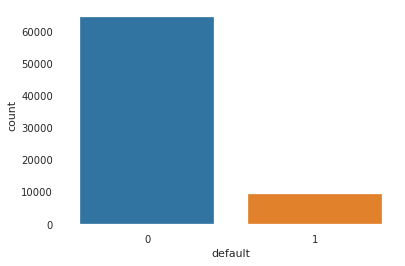

In [11]:
# Посмотрим на рспределение признака default в обучающей выбоке
sns.countplot(train['default'])

Видим, что распределение неравномерное. Клиентов, которым выдают кредит,намного больше.

### Неудобно работать поочередно с каждым датасетом, поэтому объединим данные в один

In [12]:
# Чтобы различать обущающую и тестовые выборки, создадим столбец со значениями 1 и 0
train['sample'] = 1   # обучающая выборка
test['sample'] = 0    # тестовая выборка
test['default'] = -1  # т.к. изначально в тестовых данных у нас нет переменной default, создадим столбец со значениями -1
data = train.append(test, sort=False).reset_index(drop=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [14]:
data.shape

(110148, 20)

## *Описание данных:*
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

# Визуализация данных

In [15]:
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,-1,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,-1,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,-1,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,-1,0


In [16]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating'] # Числовые переменные
cat_cols = ['education','work_address','home_address','sna','first_time'] # категориальные переменные
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] # бинарные переменные

# *Numerical*

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


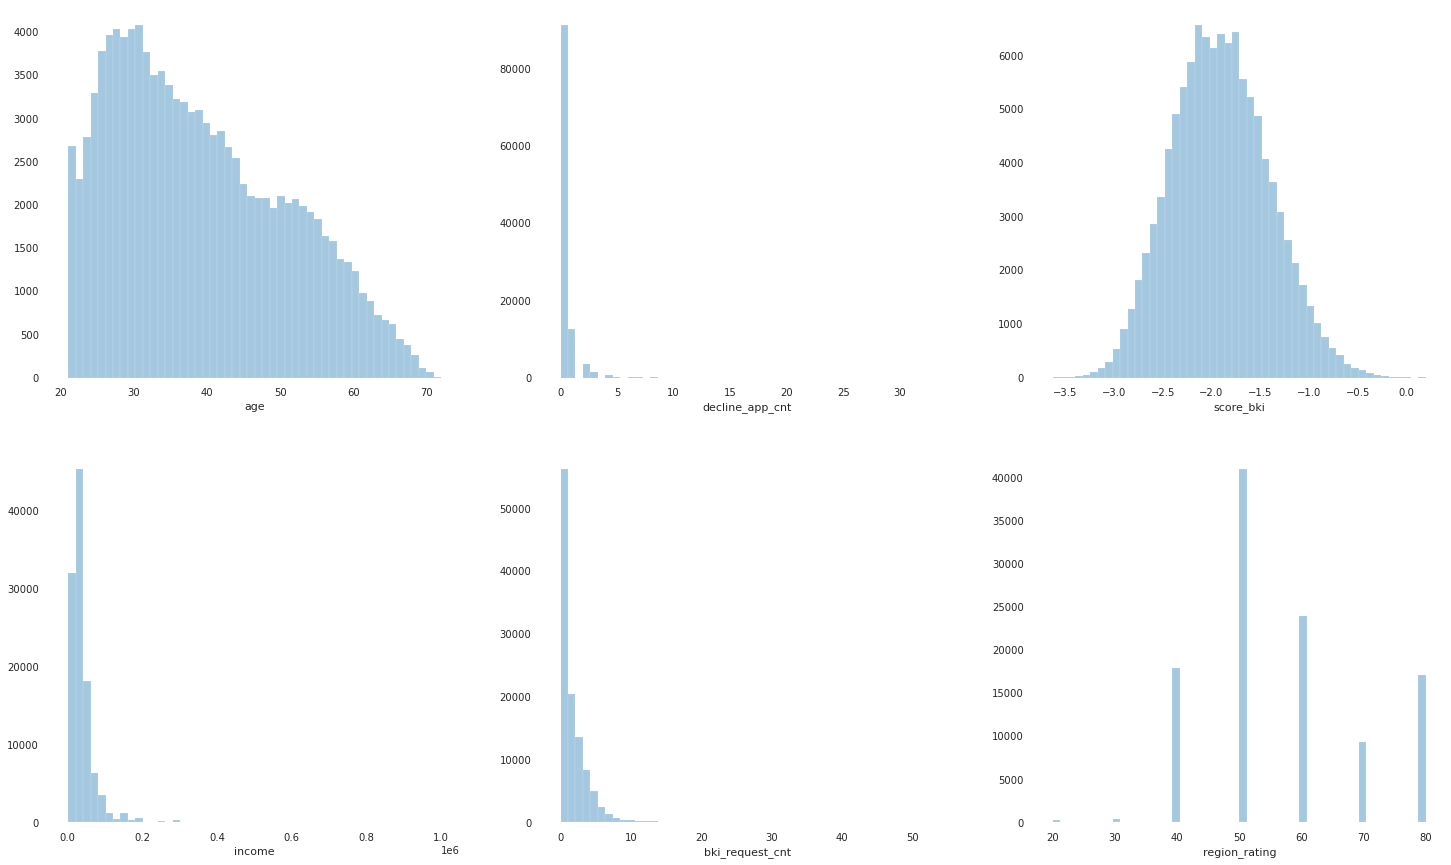

In [17]:
# Смотрим на распределение числовых данных
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i])

### Видим, что распределение совсем не похоже на нормальное...Попробуем поработать с логарифмическими величинами наших переменных.

Логарифмируем только те столбцы, распределение которых совсем не похоже на нормальное:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

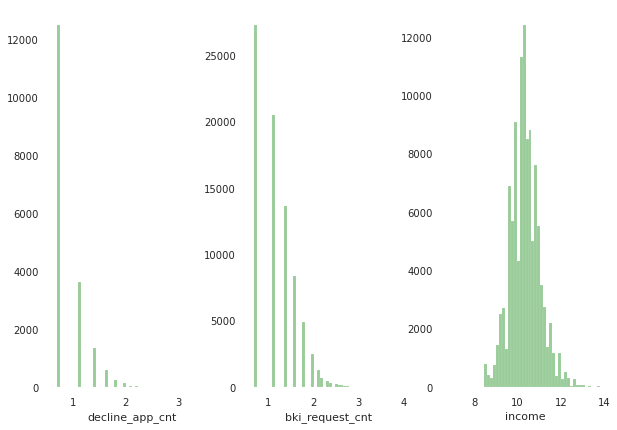

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    data[col] = np.log(data[col] + 1)
    sns.distplot(data[col][data[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False,color="g")
    #sns.distplot(data[col], kde=False, ax=axes.flat[i],color='g')
    

## Столбцы теперь выглядят лучше, но выбросы все равно есть.

### Теперь построим боксплоты для наших числовых переменных:

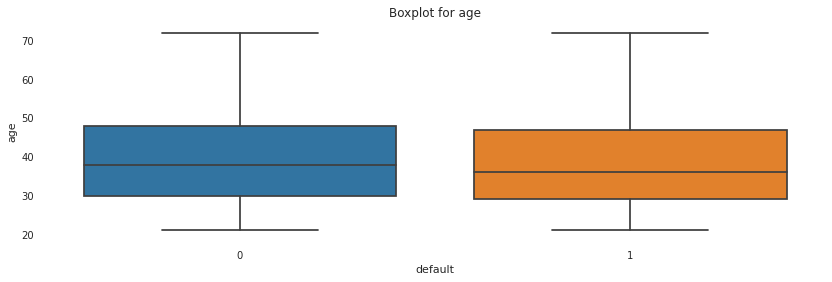

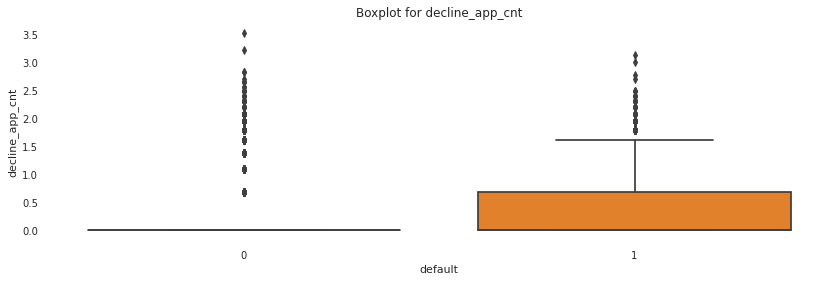

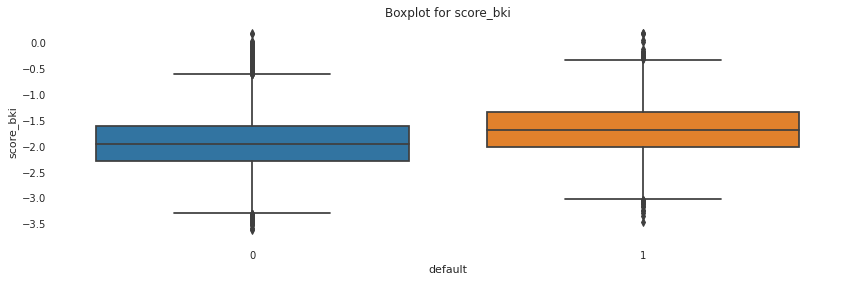

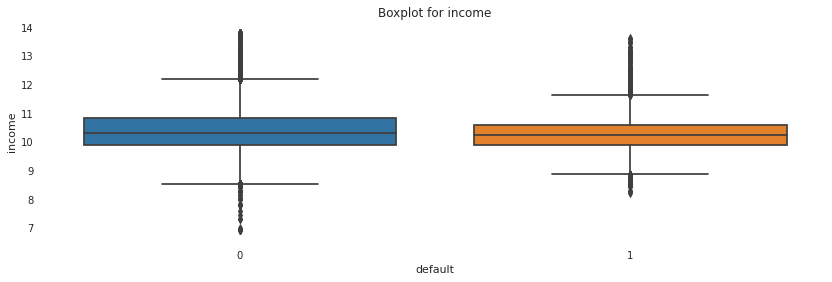

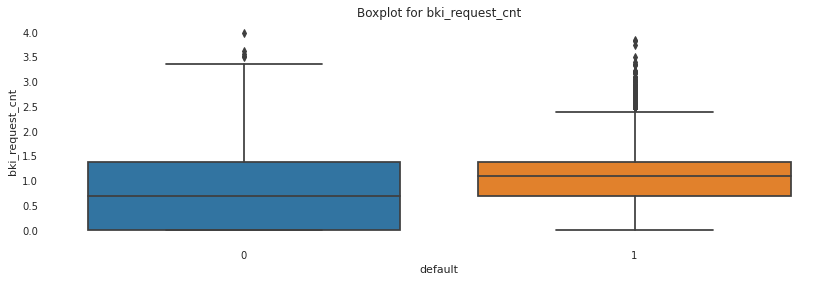

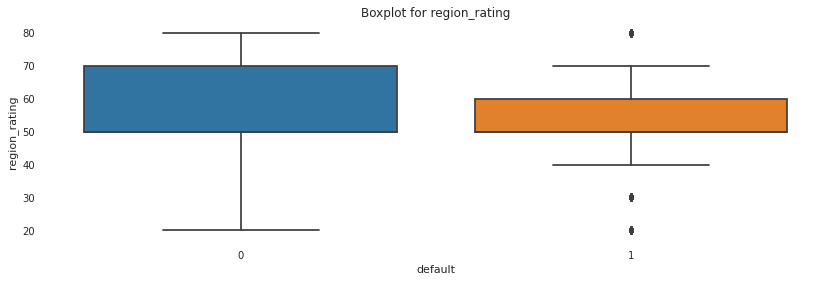

In [19]:
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=data[data['sample']==1],ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
for col in num_cols:
    boxplot(col)

1) Недефолтные клиенты, как правило, старше.

2) Скоринговый балл выше у дефолтных клиентов

3) В среднем, доход недефолтных клиентов незначительно выше, чем у дефолтных.

4) Рейттинг региона значительно влияет на положительный ответ к запросу о выдаче кредита.

5) Количество запросов в БКИ в среднем больше у недефотных клиентов.

### С выбросами разберемся позже.

# *Categorical*

<AxesSubplot:>

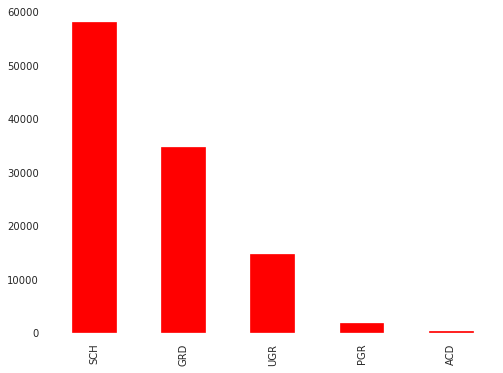

In [20]:
data.education.value_counts().plot(kind="bar",figsize=(8,6),color="r")

In [21]:
data.education.isna().value_counts()

False    109670
True        478
Name: education, dtype: int64

Пропущенные значения заменим на самое встречаемое "SCH".

In [22]:
data.education = data.education.fillna("SCH")

In [23]:
data.education.isna().value_counts()

False    110148
Name: education, dtype: int64

Смотрим зависимость дохода от уровня образования

<AxesSubplot:xlabel='education', ylabel='income'>

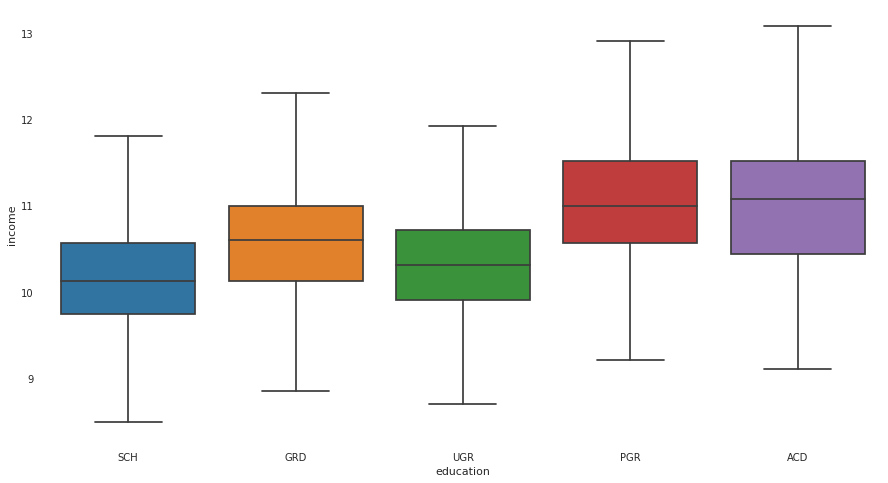

In [24]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False)

Чем выше уровень образования, тем больше доход.

<AxesSubplot:xlabel='region_rating', ylabel='score_bki'>

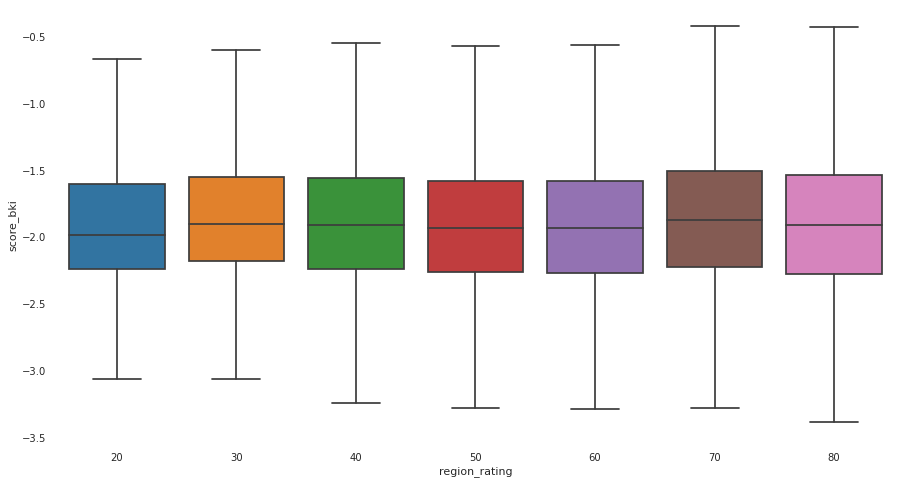

In [25]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="region_rating", y="score_bki", data=data, showfliers=False)

Рейтинг региона пусть и незначительно, но влияет на балл по БКИ.


<AxesSubplot:xlabel='education', ylabel='age'>

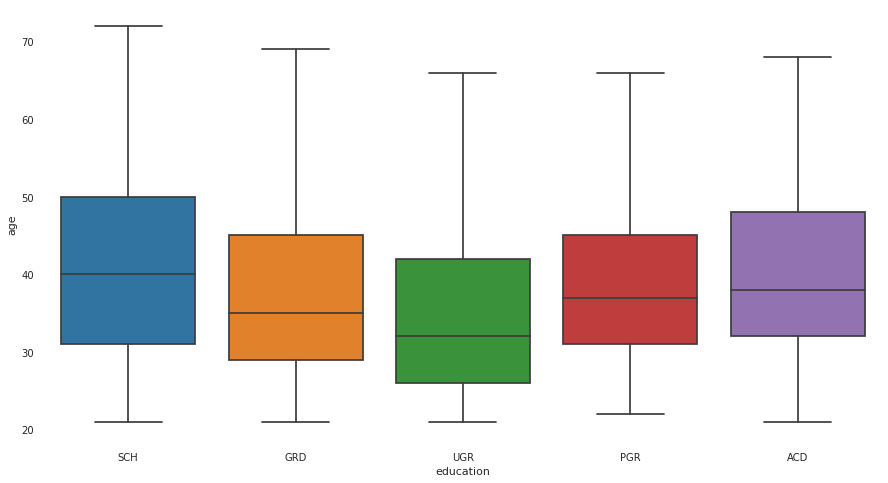

In [26]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="age", data=data, showfliers=False)

# *Binary*

<AxesSubplot:xlabel='good_work', ylabel='income'>

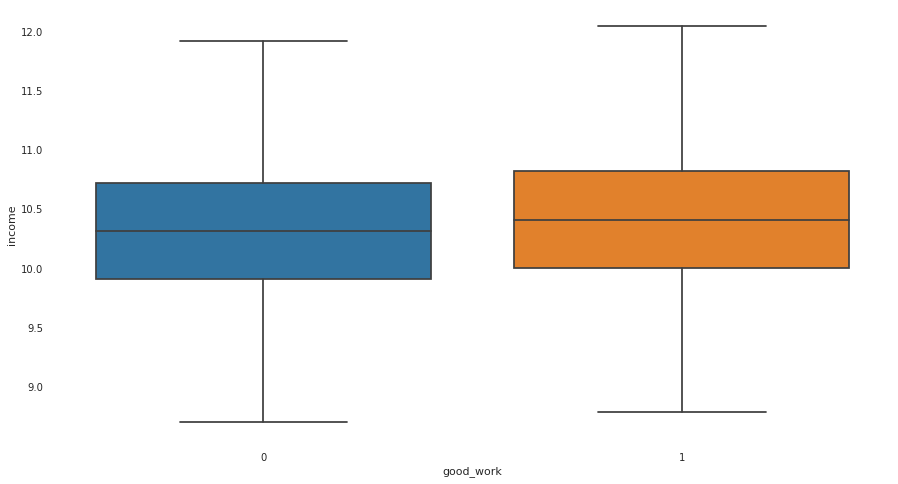

In [27]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="good_work", y="income", data=data, showfliers=False)

<AxesSubplot:xlabel='foreign_passport', ylabel='score_bki'>

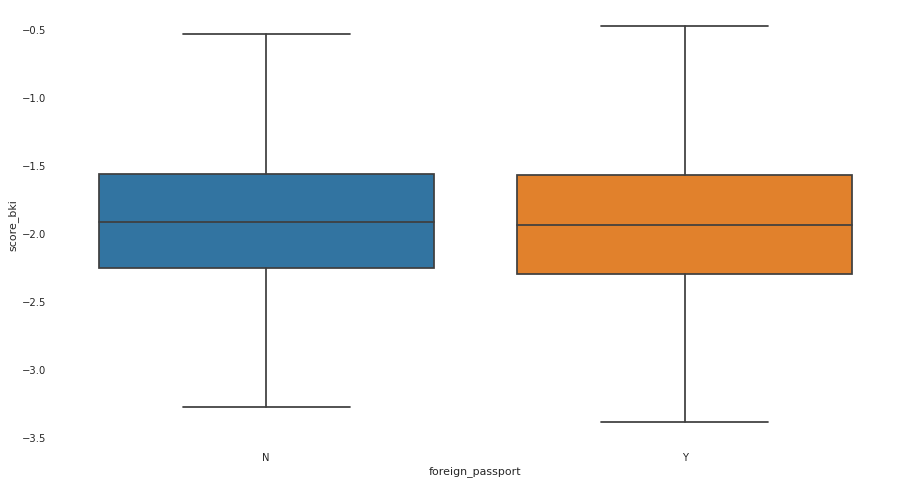

In [28]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="foreign_passport", y="score_bki", data=data, showfliers=False)

 У владельцев иностранного паспорта score_bki немного выше.

<AxesSubplot:>

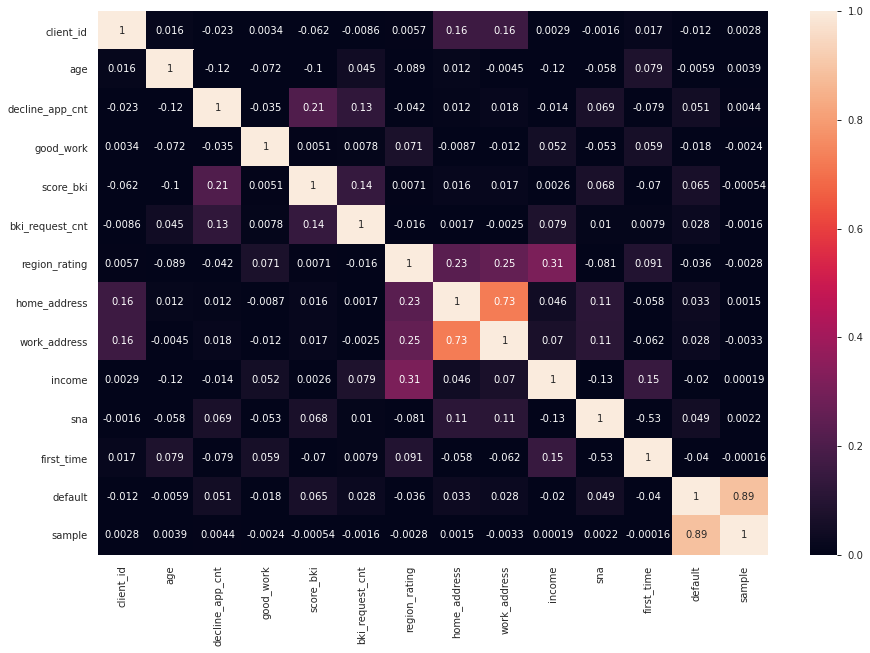

In [29]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot = True)

### Сильно коррелирующих переменных практически нет

# *EDA and feature engineering*

Начнем, пожалуй, со столбца с датами.

In [30]:
data['app_date'] = pd.to_datetime(data.app_date)

In [31]:
data['app_date'].sample(3)

59631   2014-03-28
93420   2014-03-23
48602   2014-04-03
Name: app_date, dtype: datetime64[ns]

Теперь можем посчитать количество дней, прошедших с самой первой даты в нашем датасете.

In [32]:
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days) 

In [33]:
# Запомним наш датасет на всякий случай
df = data.copy()

In [34]:
# средний доход по возрасту
mean_income = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age'] = df['age'].map(mean_income)

In [35]:
# Теперь найдем максимальный доход по возрасту
max_income = df.groupby('age')['income'].max().to_dict()
df['max_income_age'] = df['age'].map(max_income)

In [36]:
# Нормализуем
df["normalized_income"] = abs((df.income - df.mean_income_age)/df.max_income_age)

In [37]:
# Найдем среднее количество запросов в БКИ в зависимости от дохода и возраста
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

In [38]:
mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
df['mean_requests_income'] = df['income'].map(mean_bki_inc)

In [39]:
# Найдем средний уровень дохода в зависимости от рейтинга региона
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

### Теперь трансформируем наши бинарные и категориальные признаки с помощью LabelEncoder и OneHotEncoder.

In [40]:
mapped_data = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapped_data[col] = dict(enumerate(label_encoder.classes_))

In [41]:
mapped_data

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'}}

In [42]:
mapped_data_cat = {}
enc = OneHotEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapped_data_cat[col] = dict(enumerate(label_encoder.classes_))


In [43]:
mapped_data_cat

{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'},
 'work_address': {0: 1, 1: 2, 2: 3},
 'home_address': {0: 1, 1: 2, 2: 3},
 'sna': {0: 1, 1: 2, 2: 3, 3: 4},
 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}

### Переобозначим наши колонки

In [44]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample',
       'mean_income_age', 'max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'],
      dtype='object')

In [45]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','app_date', 'mean_income_age','region_rating','max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'] # Числовые переменные
cat_cols = ['education','work_address','home_address','sna','first_time'] # категориальные переменные
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] # бинарные переменные

In [46]:
len(num_cols)

13

### Найдем границы выбросов

In [47]:
for col in num_cols:
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print("Колонка ", col)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

Колонка  age
25-й перцентиль: 30.0, 75-й перцентиль: 48.0, IQR: 18.0,  Границы выбросов: [3.0, 75.0].
Колонка  decline_app_cnt
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Колонка  score_bki
25-й перцентиль: -2.2604336700000003, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Колонка  income
25-й перцентиль: 9.90353755128617, 75-й перцентиль: 10.778977123006351, IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Колонка  bki_request_cnt
25-й перцентиль: 0.0, 75-й перцентиль: 1.3862943611198906, IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Колонка  app_date
25-й перцентиль: 33.0, 75-й перцентиль: 89.0, IQR: 56.0,  Границы выбросов: [-51.0, 173.0].
Колонка  mean_income_age
25-й перцентиль: 10.305358726970132, 75-й перцентиль: 10.444420558250247, IQR: 0.13906183128011484,  Границы выбросов: [10.09676598004

<AxesSubplot:>

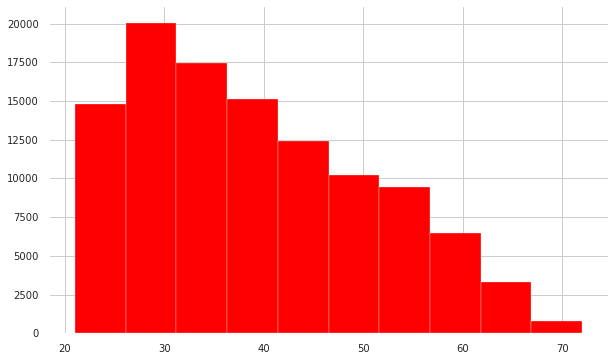

In [48]:
df.age.hist(color='r', figsize=(10,6))

<AxesSubplot:>

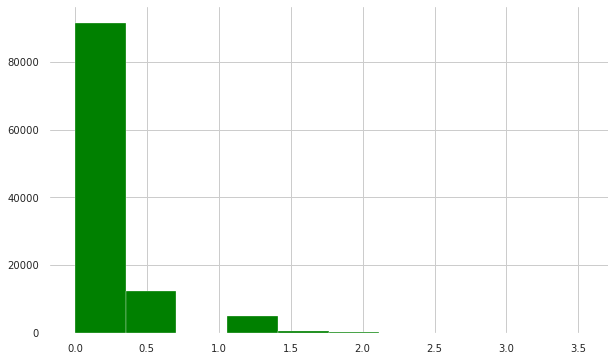

In [49]:
df.decline_app_cnt.hist(color="g",figsize=(10,6))

У данного признака очень странные границы выбросов [0,0], поэтому не будем ничего с этим делать.

<AxesSubplot:>

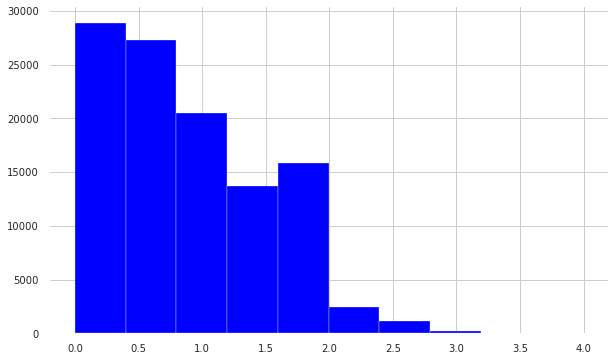

In [50]:
df.bki_request_cnt.hist(color="b",figsize=(10,6))

Выбросов нет.

<AxesSubplot:>

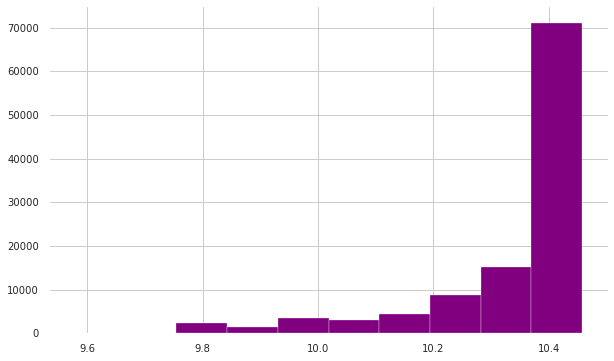

In [51]:
df.mean_income_age.hist(color="purple",figsize=(10,6))

<AxesSubplot:>

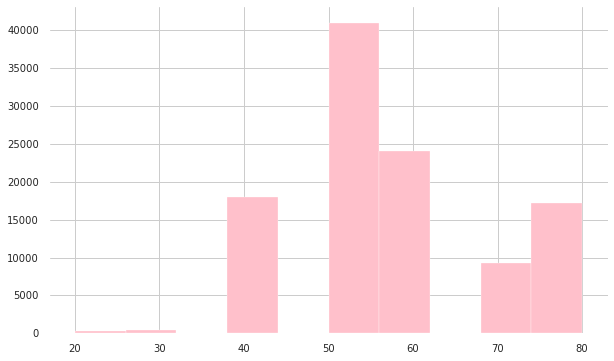

In [52]:
df.region_rating.hist(color="pink",figsize=(10,6))

## Стандартизация числовых признаков

In [53]:
dataset = df.copy() # Еще раз сохраняем наш датасет

In [54]:
dataset.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,first_time,foreign_passport,default,sample,mean_income_age,max_income_age,normalized_income,mean_requests_age,mean_requests_income,mean_income_region
0,25905,31,3,1,62,1,1,0.000000,0,-2.008753,...,0,0,0,1,9.917638,12.611541,0.009472,0.901260,0.895328,10.208090
1,63161,70,3,0,59,0,0,0.000000,0,-1.532276,...,0,0,0,1,9.997499,13.764218,0.010553,0.914524,0.941051,10.208090
2,25887,31,3,1,25,1,0,1.098612,0,-1.408142,...,3,1,0,1,10.305359,13.304687,0.000273,0.828157,0.844503,10.784262


#### Используем StandardScaler

In [55]:
dataset[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = df[num_cols].columns)


## Оценка значимости переменных

### Числовые переменные

In [56]:
data_temp = dataset.loc[data['sample'] == 1] # обучающая выборка

<AxesSubplot:>

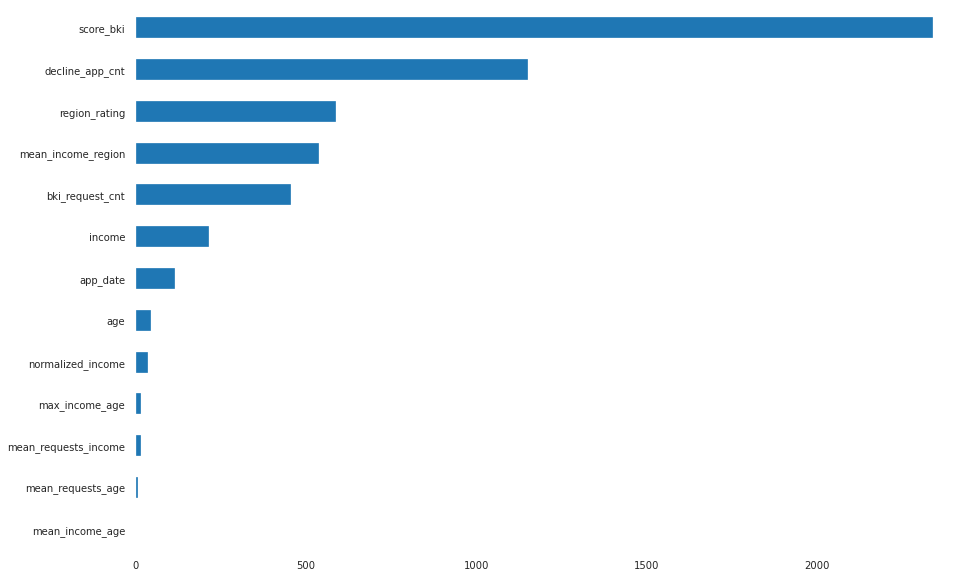

In [57]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Как можно увидеть, наибольшее влияние на "дефолтность" оказывает признак score_bki. Из всех сгенерированных признаков хоть какую-то значимость привносит признак mean_income_region.

### Категориальные и Бинарные переменные

<AxesSubplot:>

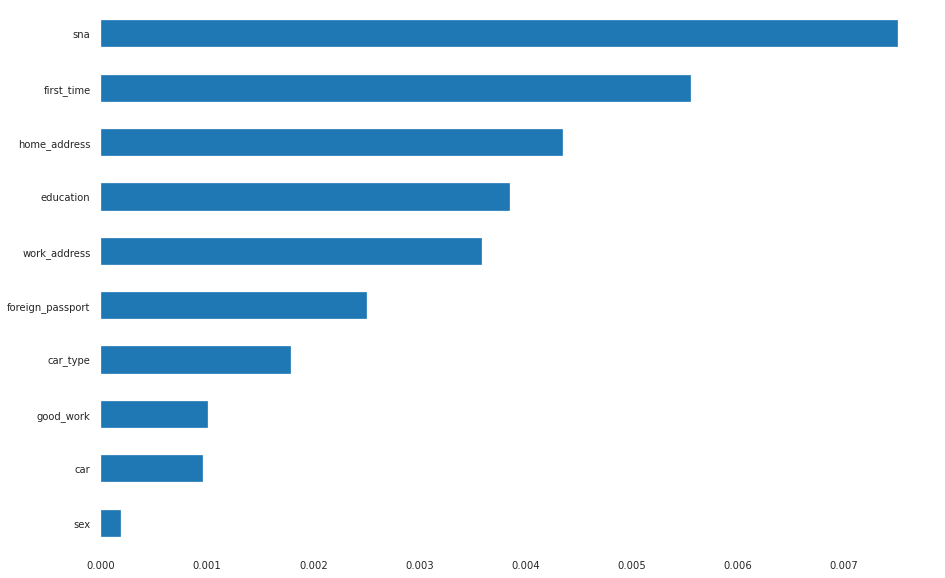

In [58]:
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Итак, здесь самым значимым является признак sna(связь заемщика с клиентами), а затем признаки first_time, home_address и education.

## *Get_dummies*

In [59]:
df = pd.get_dummies(dataset, prefix=cat_cols, columns=cat_cols) # dummy для категориальных признаков

In [60]:
data = df.copy()

In [61]:
data.head(3)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_1,home_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
0,25905,-0.934391,1,1.975219,1,1,-0.418815,0,-0.208688,-0.281790,...,0,0,0,0,0,1,1,0,0,0
1,63161,0.281474,0,1.714757,0,0,-0.418815,0,0.745419,0.770563,...,1,0,0,0,0,1,1,0,0,0
2,25887,-0.934391,1,-1.237142,1,0,2.621662,0,0.993988,-0.281790,...,0,0,1,0,0,0,0,0,0,1


# Строим модель

In [62]:
train_df = df.query('sample == 1').drop(['sample','client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample','client_id'], axis=1)

In [63]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values # целевая переменная

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [65]:
# Логистическая регрессия 
model = LogisticRegression(max_iter = 1000)

In [66]:
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

## **Кривая ROC AUC**

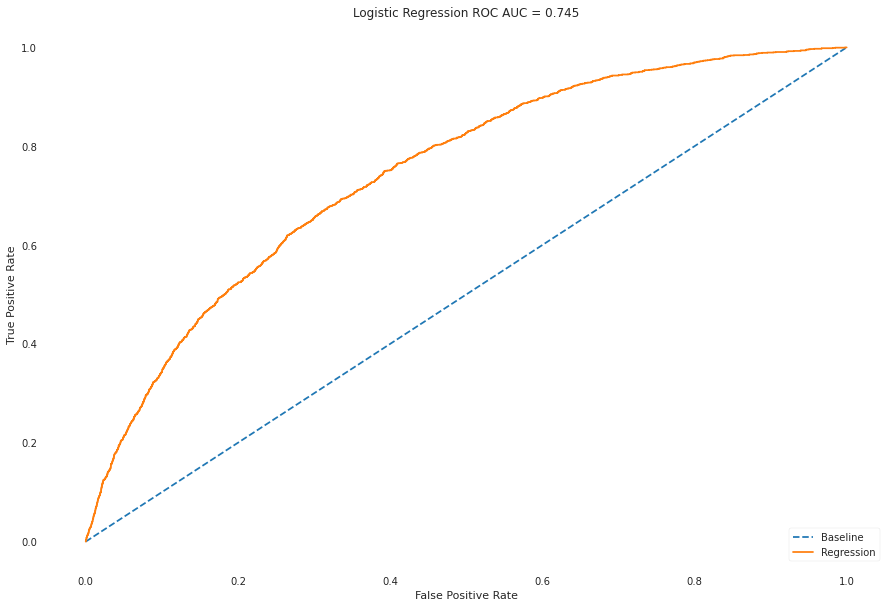

In [67]:
probs = model.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Значение ROC AUC довольно высоко, но попробуем улучшить его с помощью подбора гипермараметров.

In [68]:
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

accuracy_score: 0.875
precision_score: 0.41346153846153844
recall_score: 0.02353585112205802
f1_score: 0.044536509580528225


Судя по метрикам, модель достаточно плохо справляется...

### Confusion matrix

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

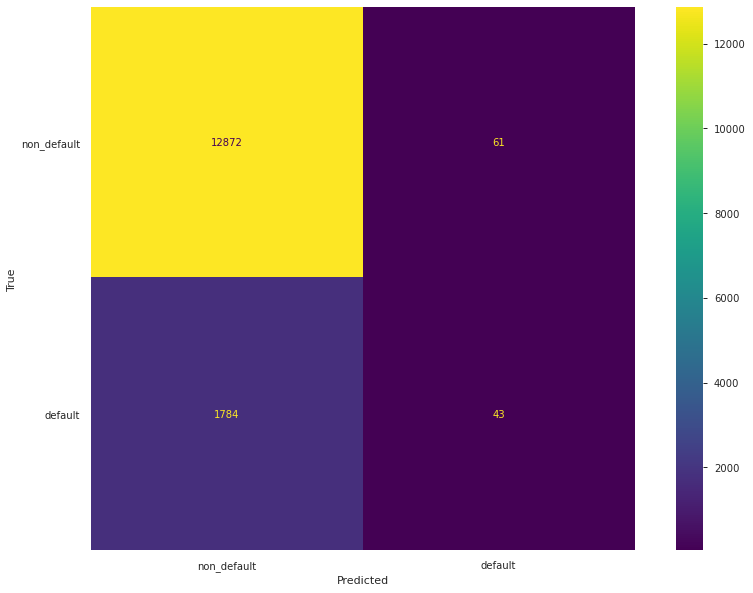

In [69]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Недефолтных клиентов модель предсказывает хорошо: 12880 из 14665, т.е. 87.8 %, однако, дефолтных клиентов модель предсказывает не так хорошо: 53 из 95, т.е. 56.7%, что мне кажется плохим результатом. Получается, наша модель будет выдавть кредит практически всем клиентам....Возможно, это связано с несбалансированностью нашей выборки.
Попробуем обучить модель с гиперпараметрами.

# Модель с гиперпараметрами

### Используем RandomizedSearchCV. Помог данный сайт: http://espressocode.top/ml-hyperparameter-tuning/

In [70]:
train_df = df.query('sample == 1').drop(['sample','client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample','client_id'], axis=1)

In [71]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values # целевая переменная

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [73]:
param_dist = {"max_depth": [3, None],

              "max_features": randint(1, 9),

              "min_samples_leaf": randint(1, 9),

              "criterion": ["gini", "entropy"]}

In [74]:
 tree = DecisionTreeClassifier() # дерево решений

In [75]:
# Создание объекта RandomizedSearchCV
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 5)

In [76]:
model_2 = tree_cv.fit(X_train, y_train)

In [77]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Результат: {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8}
Результат: 0.87220311982488


Обучаем с параметрами

In [78]:
 tree = DecisionTreeClassifier(criterion='gini',max_depth=3, max_features=7, min_samples_leaf=5)

In [79]:
model_2 = tree.fit(X_train, y_train)

## Кривая ROC AUC

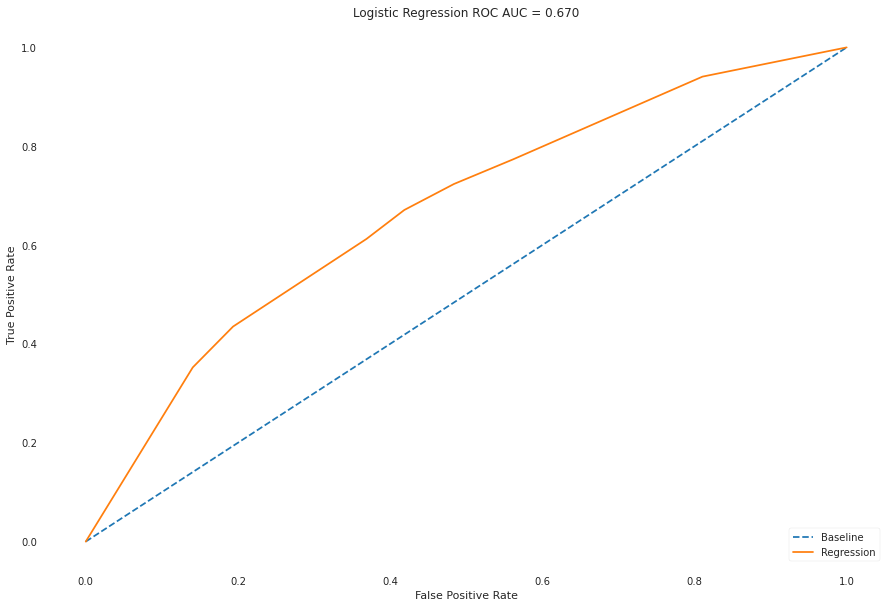

In [80]:
probs = model_2.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Значение ROC AUC уменьшилось :(

### Пробуем использовать GridSearchCV

#### Код для поиска параметров подсмотрен у [данного](http://www.kaggle.com/sokolovaleks/sf-dst-10-creditscoring-golobokov-sokolov) автора

In [81]:
iter_ = 15
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_valid)
print('Accuracy: %.4f' % accuracy_score(y_valid, preds))
print('Precision: %.4f' % precision_score(y_valid, preds))
print('Recall: %.4f' % recall_score(y_valid, preds))
print('F1: %.4f' % f1_score(y_valid, preds))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.34027268        nan
 0.34037431        nan 0.05781712 0.05751194        nan 0.05708575
 0.05732705 0.05781712 0.05751194        nan 0.05708147 0.05732705
 0.34022758 0.33997715 0.34022762 0.34042106 0.34024062 0.34022758
 0.33997715 0.34022762 0.34027336 0.34028642 0.05780893 0.05751194
 0.05756412 0.05757185 0.05780893 0.05751194 0.05781712 0.05757185
 0.34021569 0.33999986 0.34020282 0.34026357 0.34021569 0.33999986
 0.34000186 0.34027514]
  category=UserWarning


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 15
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6700
Precision: 0.2258
Recall: 0.6858
F1: 0.3397


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Подстраиваем параметры

In [82]:
best_model = LogisticRegression(random_state=42, C=1,  class_weight='balanced', dual=False, 
                            fit_intercept=True, intercept_scaling=1, l1_ratio=None, multi_class='auto',
                             n_jobs=None, penalty='l1', solver='saga',tol=0.001, verbose=0, warm_start=False,max_iter=1000)

best_model.fit(X_train, y_train)
y_pred_prob = best_model.predict_proba(X_valid)[:,1]
y_pred = best_model.predict(X_valid)

In [83]:
y_pred_prob

array([0.62865162, 0.57753206, 0.33041184, ..., 0.44114756, 0.46396166,
       0.34036064])

In [84]:
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

accuracy_score: 0.6699864498644986
precision_score: 0.22566690699351116
recall_score: 0.6852764094143404
f1_score: 0.33952542372881356


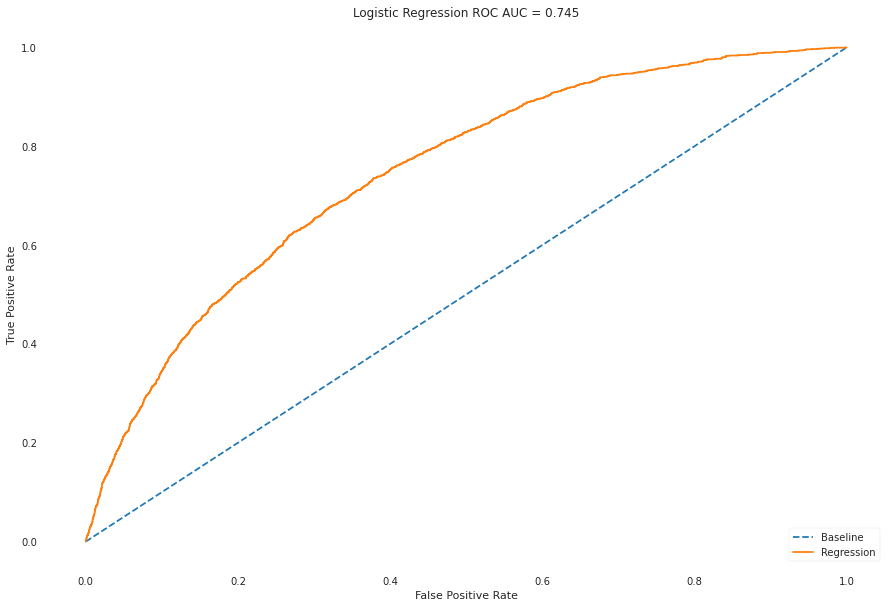

In [85]:
probs = best_model.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Даже с гиперпараметрами значение ROC AUC не изменилось. Зато видно улучшение в значении некоторых метрик.

# SUBMISSION

In [86]:
train_data = data.query('sample == 1').drop(['sample','client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample','client_id'], axis=1)

In [87]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [88]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (73799,), (36349, 37))

In [89]:
last_model = LogisticRegression(random_state=42, C=1,  class_weight='balanced', dual=False, 
                            fit_intercept=True, intercept_scaling=1, l1_ratio=None, multi_class='auto',
                             n_jobs=None, penalty='l1', solver='saga',tol=0.001, verbose=0, warm_start=False,max_iter=1000)

last_model.fit(X_train, y_train)
y_pred_prob = last_model.predict_proba(X_test)[:,1]
y_pred = last_model.predict(X_test)

In [90]:
submit = pd.DataFrame(test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [91]:
display(submit)

,client_id,default
0,74835,0.205956
1,17527,0.803475
2,75683,0.322499
3,26883,0.387106
4,28862,0.141541
...,...,...
36344,83775,0.785098
36345,106254,0.082720
36346,81852,0.790978
36347,1971,0.637193
